# Neural & Behavioral Modeling - Week 11 (Exercises)
by 李彥廷 (b08207008@ntu.edu.tw)

In [50]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import pandas as pd
from tabulate import tabulate

In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
Device  0 : Tesla T4
Current: Device  0


## 1 Fair Performance Evaluation (2 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (2 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [3]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True, transform=transforms.ToTensor(),download=True)
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### 1.1 The model

In [4]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in (depth: rgb), out(6 feature map), kernel(5x5)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing

In [5]:
# Training:
for e in range(2):
    for i, (X_train, Y_train) in enumerate(train_data, 0):
        X_train,Y_train=X_train.to(device),Y_train.to(device)
        Y_pred = lenet(X_train)
        loss = loss_fn(Y_pred, Y_train)
        lenet.zero_grad()
        loss.backward()
        optimizer.step()   
        Y_pred = lenet(X_train)
        Y_pred = t.max(Y_pred,1)[1]
    print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
    
# Testing on a batch:
testAccList = []
for i in range(10):
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1] # axis=1, 1 is index
        Acc = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
        print('test :',Acc)
        testAccList.append(Acc)

epoch  0 : 0.6875
epoch  1 : 0.5
test : 0.527
test : 0.537
test : 0.487
test : 0.5
test : 0.528
test : 0.514
test : 0.529
test : 0.521
test : 0.525
test : 0.487


### 1.3 Your answers

Please respond to the questions here.

In [6]:
print('min : ', min(testAccList))
print('max : ', max(testAccList))
print('mean: ', round(np.mean(testAccList),3))
print('std : ', np.std(testAccList))

min :  0.487
max :  0.537
mean:  0.516
std :  0.017089470442351352


In [7]:
# fix random seed
testAccList = []
for i in range(10):
    np.random.seed(0)
    t.manual_seed(0)
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1] # axis=1, 1 is index
        Acc = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
        print('test :',Acc)
        testAccList.append(Acc)
print('----------------------')
print('min : ', min(testAccList))
print('max : ', max(testAccList))
print('mean: ', round(np.mean(testAccList),3))
print('std : ', round(np.std(testAccList),3))

test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
test : 0.508
----------------------
min :  0.508
max :  0.508
mean:  0.508
std :  0.0


## 2 Universal Approximation Theorem (4 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

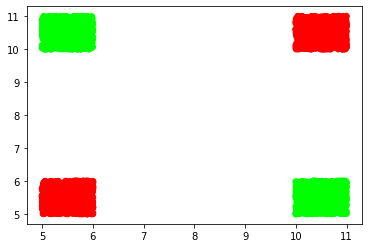

In [8]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [ ]:
# Number of free parameters: 2*H+H*2=48

H=12 # number of hidden units
IO = 2
NofParams = IO*H + H*IO
model = t.nn.Sequential(
    t.nn.Linear(IO, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, IO, bias=False),
    t.nn.Softmax(dim=1)
)

loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())
for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

#### 2.2 A "deep" net with three hidden layers

In [ ]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48
H=4 # number of hidden units
IO = 2
NofParams = IO*H + H*H + H*H + H*IO
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False), # 2*H
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(), 

    t.nn.Linear(H, H, bias=False), # H*H
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),

    t.nn.Linear(H, H, bias=False), # H*H
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),

    t.nn.Linear(H, 2, bias=False), # H*2
    t.nn.Softmax(dim=1)
)

loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())
for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

### 2.3 Your answers

Please respond to the questions here.

In [11]:
class Model:

    def __init__(self, isDeep, H):
        self.IO = 2
        self.H = H
        self.NoParams = None
        self.model = None
        self.AccList = []
        if isDeep: self.deep()
        else: self.shallow()

    def shallow(self):
        self.NoParams = self.IO*self.H + self.H*self.IO
        self.model = t.nn.Sequential(
            t.nn.Linear(self.IO, self.H, bias=False),
            t.nn.BatchNorm1d(self.H),
            t.nn.ReLU(),
            t.nn.Linear(self.H, self.IO, bias=False),
            t.nn.Softmax(dim=1)
        )

    def deep(self):
        self.NoParams = self.IO*self.H + self.H*self.H + self.H*self.H + self.H*self.IO
        self.model = t.nn.Sequential(
            t.nn.Linear(2, self.H, bias=False), # 2*H
            t.nn.BatchNorm1d(self.H),
            t.nn.ReLU(), 
            t.nn.Linear(self.H, self.H, bias=False), # H*H
            t.nn.BatchNorm1d(self.H),
            t.nn.ReLU(),
            t.nn.Linear(self.H, self.H, bias=False), # H*H
            t.nn.BatchNorm1d(self.H),
            t.nn.ReLU(),
            t.nn.Linear(self.H, 2, bias=False), # H*2
            t.nn.Softmax(dim=1)
        )  

    def train(self, epoch=100):
        loss_fn = t.nn.CrossEntropyLoss()
        optimizer = t.optim.Adam(self.model.parameters())
        for i in range(100):
            z_pred = self.model(xy)
            loss = loss_fn(z_pred,z)
            self.model.zero_grad()
            loss.backward()
            optimizer.step()
            z_pred = self.model(xy) 
            z_pred = t.max(z_pred,1)[1]
            # print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])
            self.AccList.append((z_pred==z).sum().item()/xy.shape[0])




以下對不同參數數量跑了各自20次的模擬，每次都計算出100個epoch中最後一個的正確率並記錄。

In [72]:
HiddenLayerNodes = np.arange(4, 13, 2)
deepAccListAll = []
deepNumParamList = []
for NumNodes in HiddenLayerNodes:
    deepAccList = []
    for i in range(40):
        deep = Model(isDeep=True, H=NumNodes)
        deep.train()
        deepAccList.append(deep.AccList[-1])
    deepNumParamList.append(deep.NoParams)
    print(deepAccList)
    deepAccListAll.append(deepAccList)

[0.75, 0.75, 0.75, 1.0, 0.75, 0.75, 0.999, 0.75, 1.0, 0.9915, 1.0, 0.5, 1.0, 0.5, 0.77875, 1.0, 0.5, 1.0, 0.75125, 0.75, 0.748, 0.75, 0.737, 1.0, 0.787, 0.75, 1.0, 0.75, 0.75, 1.0, 0.98175, 0.95475, 0.75, 1.0, 0.9295, 0.98325, 0.75, 0.73225, 0.99775, 1.0]
[1.0, 1.0, 1.0, 0.99875, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.82175, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.73225, 1.0, 1.0, 1.0, 1.0, 1.0, 0.931, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.963, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [73]:
deepAccListAll = np.array(deepAccListAll)
deepAccMeanList = np.round(deepAccListAll.mean(axis=1), 4)
deepAccStdList = np.round(deepAccListAll.std(axis=1), 4)
table = np.array([deepNumParamList, deepAccMeanList, deepAccStdList]).T
headers = ['#Params','MeanAcc','StdAcc']
print(tabulate(table, headers, tablefmt='simple'))

  #Params    MeanAcc    StdAcc
---------  ---------  --------
       48     0.8405    0.1511
       96     0.9371    0.1061
      160     0.9866    0.0546
      240     0.9938    0.039
      336     0.9875    0.0545


可以看到在deep的模型下，當參數數量愈多，正確率就會越高，結果也會越穩定

In [44]:
deepAccStdList

array([0.16602056, 0.08137561, 0.07469308, 0.        , 0.        ])

In [77]:
HiddenLayerNodes = np.arange(12, 96, 12)
shallowAccListAll = []
shallowNumParamList = []
for NumNodes in HiddenLayerNodes:
    shallowAccList = []
    for i in range(40):
        shallow = Model(isDeep=False, H=NumNodes)
        shallow.train()
        shallowAccList.append(shallow.AccList[-1])
    shallowNumParamList.append(shallow.NoParams)
    print(shallowAccList)
    shallowAccListAll.append(shallowAccList)

[0.88525, 0.75, 1.0, 1.0, 0.89425, 1.0, 0.72925, 0.96, 0.991, 1.0, 1.0, 0.9395, 1.0, 0.99825, 1.0, 0.75, 0.981, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.715, 0.75, 1.0, 0.99925, 1.0, 0.75, 1.0, 1.0, 1.0, 0.9845, 1.0, 1.0, 0.75, 1.0, 0.75, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [78]:
shallowAccListAll = np.array(shallowAccListAll)
shallowAccMeanList = np.round(shallowAccListAll.mean(axis=1), 4)
shallowAccStdList = np.round(shallowAccListAll.std(axis=1), 4)
table = np.array([shallowNumParamList, shallowAccMeanList, shallowAccStdList]).T
headers = ['#Params','MeanAcc','StdAcc']
print(tabulate(table, headers, tablefmt='simple'))

  #Params    MeanAcc    StdAcc
---------  ---------  --------
       48     0.9394    0.1016
       96     1         0
      144     1         0
      192     1         0
      240     1         0
      288     1         0
      336     1         0


可以看到shallow network在參數超過96個之後就每次都達到100%的正確率

# Conclusion

從以上的模擬可以看出shallow network的表現比較好，可能是因為在XOR這樣較簡單的問題上面，不需要太多層的轉換就能做好，而deep network因為太多的計算導致在學習的過程中比較難達到最好的weight.

